In [1]:
import pandas as pd
import datetime as dt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import re
import os
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from nltk import tokenize
import pyLDAvis
from tqdm import tqdm
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Tratamento dados

In [2]:
df_data = pd.read_hdf('Carta_Capital_1000pag.hdf', key = 'hdf')

In [3]:
df = df_data.copy()
df.columns = ['Data','Titulo','Texto']

In [4]:
def data_transform(data):
    dict_data = {
    'JAN': '01',
    'FEV': '02',
    'MAR': '03',
    'ABR': '04',
    'MAIO': '05',
    'JUN': '06',
    'JUL': '07',
    'AGO': '08',
    'SET': '09',
    'OUT': '10',
    'NOV': '11',
    'DEZ': '12'
}
    
    data = data.split()
    data[1] = dict_data[data[1]]
    data = '/'.join(data)
    return dt.datetime.strptime(data,'%d/%m/%Y')

In [5]:
df["Data"] = df["Data"].apply(data_transform)


In [6]:
df.head()

,Data,Titulo,Texto
0,2019-10-11,Bonecas negras ressaltam importância da divers...,"[, , Lembrou-se da infância, em que os desenho..."
1,2019-09-03,“Bolsonaro não esconde o objetivo de destruir ...,"[, , , , CartaCapital: Como o avanço das queim..."
2,2019-08-19,Damares publica decreto que extingue comitês d...,"[, , O ministério informou que o decreto publi..."
3,2019-04-12,Especialistas avaliam fim de secretaria ligada...,"[Por Júlia Daher, Tão logo assumiu o Ministéri..."
4,2019-03-28,Diversidade é “palavra da vez” e gera até cons...,"[, A questão que fica é: se vivemos em um mund..."


In [7]:
df = df.sort_values(by='Data',ascending=False).reset_index(drop = True)

In [8]:
df = df.drop_duplicates(subset=['Titulo'], keep=False)

#### Quantidade de palavras

In [ ]:
df_word = df.copy()

df_word['Texto'] = df_word['Texto'].apply(lambda x: ' '.join(x).split()) 

In [ ]:
def data_transform(words):
    total = [x.lower() for x in words]
    total = [re.sub(r'[,\.!?()]', '', x) for x in total]
    manual_list_stop_words = ['ser','sobre','ainda','se','além', 'outros','porque','assim','ter']
    stop_words = stopwords.words('portuguese')
    for i in manual_list_stop_words:
        stop_words.append(i)
    
    total = [x for x in total if x not in stop_words]
    total = [x for x in total if not re.search(r"\d", x)]
    
    long_string = (" ").join(total)
    return long_string

In [ ]:
df_word['Texto'] = df_word['Texto'].apply(data_transform)

In [ ]:
df_word['Texto'].head()

0    páreo eleitoral bolívia ganhou improvável azar...
1    imagem estampada peito vez fazer referência gr...
2    texto autoria bancada religiosa assinado verea...
3    horas manhã domingo outubro francisco pronunci...
4    espírito santo poderia inspirado papa convocar...
Name: Texto, dtype: object

In [ ]:
def plot_n_most_common_words(count_data, count_vectorizer, n):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 10/1.6180))
    plt.subplot(title=f'{n} most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

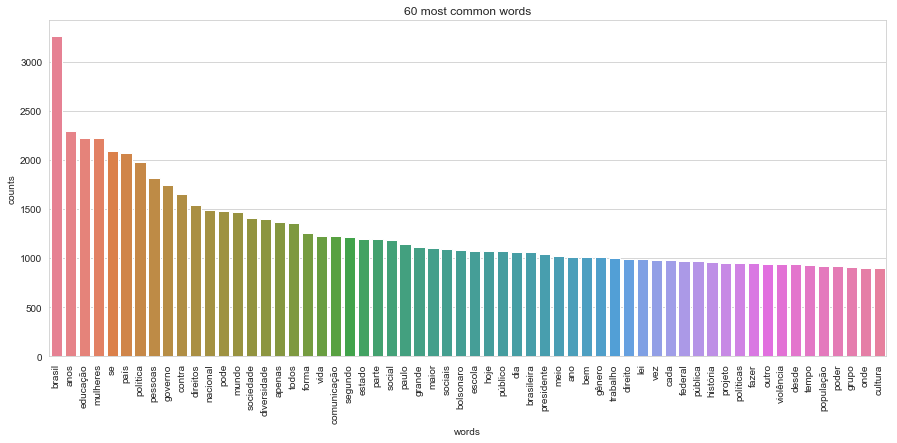

In [ ]:
count_vectorizer = CountVectorizer()

count_data = count_vectorizer.fit_transform(df_word['Texto'])
                                               
plot_n_most_common_words(count_data, count_vectorizer,60)                                               

#### WordCloud

In [ ]:
wordcloud_string = ' '.join(df_word['Texto'].values)

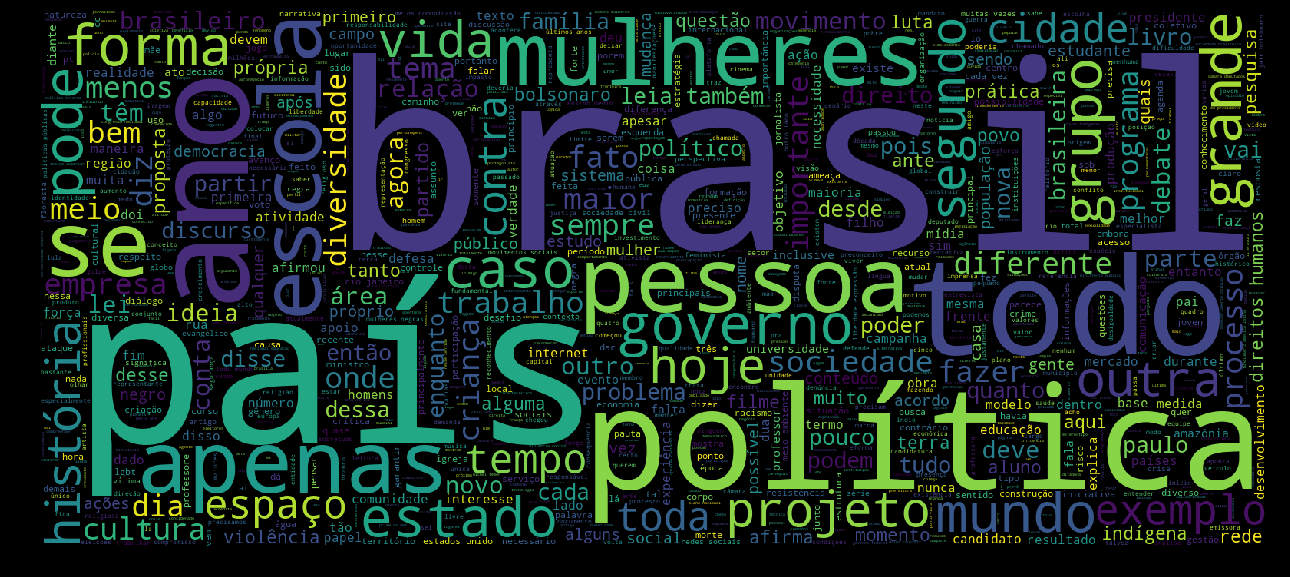

<Figure size 432x288 with 0 Axes>

In [ ]:
wordcloud = WordCloud(max_words=1000,width=1600, height=700, contour_width=20)
wordcloud.generate(wordcloud_string)
plt.figure( figsize=(22,12), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.savefig('worcloud_Pasztor.png', facecolor='k', bbox_inches='tight')

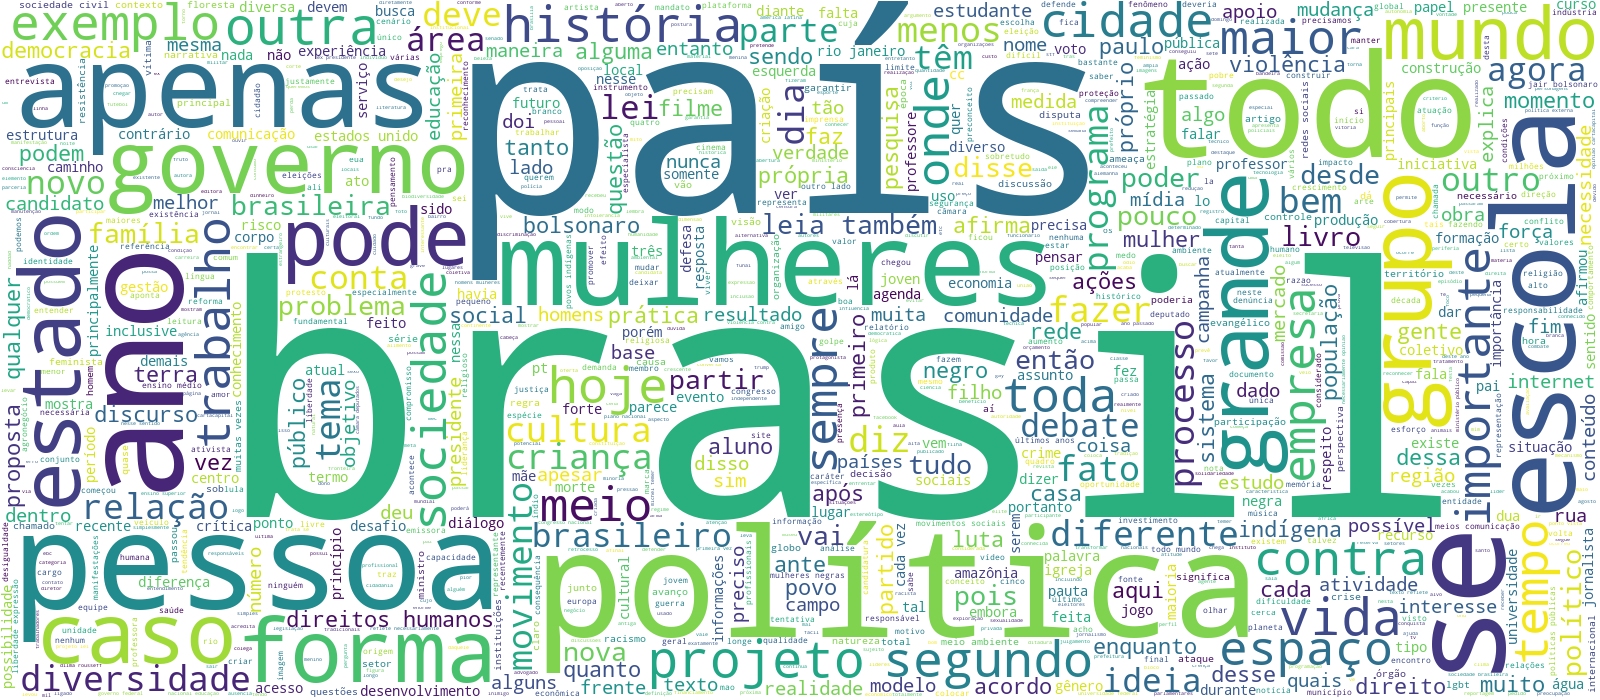

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=20,width=1600, height=700, contour_color='steelblue')
wordcloud.generate(wordcloud_string)
wordcloud.to_image()

In [ ]:
len(wordcloud_string.split())

745628

In [ ]:
df.to_csv('Textos_Carta_Capital.csv', index = False)

#### Topic LDA

In [ ]:
count_vectorizer = CountVectorizer()

count_data = count_vectorizer.fit_transform(df_word['Texto'])

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 2
number_words = 3
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
brasil mulheres política

Topic #1:
educação anos escola


In [ ]:
%%time
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
#pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_setences'+'.html')